<a href="https://colab.research.google.com/github/stevengregori92/RNN-Intro/blob/main/Try_GRU_but_failed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install 'jcopdl<2.0'
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#Import Dataset

In [4]:
!gdown https://drive.google.com/uc?id=1tWKRlxNcMCodofXVjd5qewqxLPioQFNS

Downloading...
From: https://drive.google.com/uc?id=1tWKRlxNcMCodofXVjd5qewqxLPioQFNS
To: /content/archive.zip
100% 123k/123k [00:00<00:00, 85.9MB/s]


In [5]:
!gdown https://drive.google.com/uc?id=18y76hccJ6C7CD0uMJ2KjSFGJhYx168sR

Downloading...
From: https://drive.google.com/uc?id=18y76hccJ6C7CD0uMJ2KjSFGJhYx168sR
To: /content/utils.py
100% 1.71k/1.71k [00:00<00:00, 11.2MB/s]


In [6]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: Microsoft Stocks.csv    


In [22]:
df = pd.read_csv('Microsoft Stocks.csv', parse_dates=['Date'])
df['quarter'] = df.Date.dt.quarter
df = pd.get_dummies(df, columns=['quarter'])
df.set_index('Date', inplace=True)
df.head()

,Price,Open,High,Low,Volume,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,,,,,
2023-05-15,309.46,309.10,309.90,307.59,16290000,0,1,0,0
2023-05-12,308.97,310.55,310.65,306.60,19770000,0,1,0,0
2023-05-11,310.11,310.10,311.12,306.26,31680000,0,1,0,0
2023-05-10,312.31,308.62,313.00,307.67,30080000,0,1,0,0
2023-05-09,307.00,308.00,310.04,306.31,21340000,0,1,0,0


In [23]:
df.Price = df.Price.transform(lambda x: (x - x.mean()) / x.std())

<Axes: xlabel='Date'>

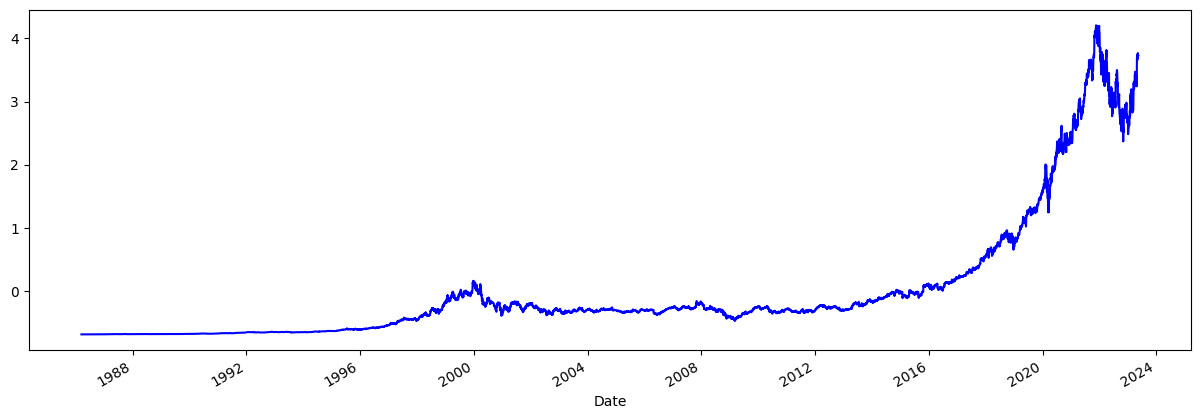

In [24]:
df.Price.plot(figsize=(15,5), color = 'b')

#Dataset Splitting

In [25]:
ts_train, ts_test = train_test_split(df, test_size=.2, shuffle = False)
ts_train.shape, ts_test.shape

((7495, 9), (1874, 9))

#Dataset & Dataloader

In [26]:
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [27]:
seq_len = 7
bs=128

train_set = TimeSeriesDataset(ts_train, 'Price', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'Price',seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (1070, 7, 9)
Note: last 4 data excluded

(N, S, F): (267, 7, 9)
Note: last 4 data excluded



#Arsitektur & Config

In [28]:
class GRU(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    
  def forward(self, x, hidden):
    x, hidden = self.rnn(x, hidden)
    x = self.fc(x)
    return x, hidden

In [29]:
train_set.n_feature

9

In [30]:
config = set_config({
    'input_size': train_set.n_feature,
    'output_size': 1,
    'hidden_size': 64,
    'num_layers': 4,
    'dropout':  0,
    'seq_len': train_set.n_seq
})

#Training -> MCOC

In [31]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
callback = Callback(model, config, outdir='model/GRU')

#Training

In [32]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device) # corrected line
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        
    cost = cost/len(dataset)
    return cost

Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.2369 | Test_cost  = 0.4914 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 1.1495 | Test_cost  = 0.5349 | 
==> EarlyStop patience =  1 | Best test_cost: 0.4914


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 1.1353 | Test_cost  = 0.5483 | 
==> EarlyStop patience =  2 | Best test_cost: 0.4914


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 1.1303 | Test_cost  = 0.5504 | 
==> EarlyStop patience =  3 | Best test_cost: 0.4914


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 1.1285 | Test_cost  = 0.5490 | 
==> EarlyStop patience =  4 | Best test_cost: 0.4914


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 1.1280 | Test_cost  = 0.5472 | 
==> EarlyStop patience =  5 | Best test_cost: 0.4914
==> Execute Early Stopping at epoch: 6 | Best test_cost: 0.4914
==> Best model is saved at model/GRU


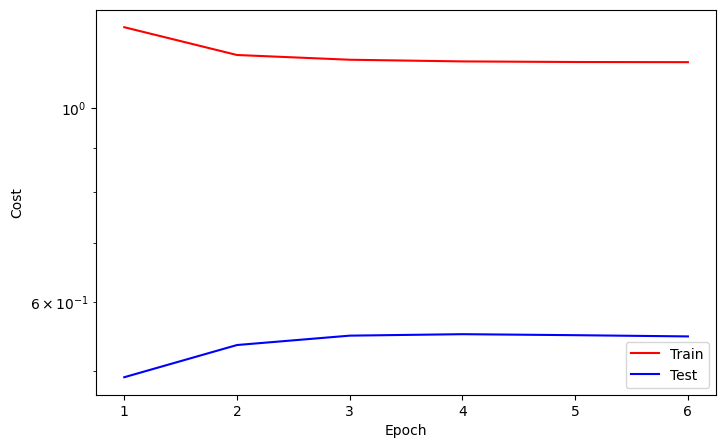

In [33]:
while True:
  train_cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
      test_cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime Plotting
  callback.cost_runtime_plotting()

  #Early Stopping
  if callback.early_stopping(model, monitor='test_cost'):
    callback.plot_cost()
    break

#Forecast

In [34]:
from utils import data4pred, pred4pred

In [35]:
train_forecast_set = TimeSeriesDataset(ts_train, 'Price', 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, 'Price', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (7494, 1, 9)
Note: last 0 data excluded

(N, S, F): (1873, 1, 9)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

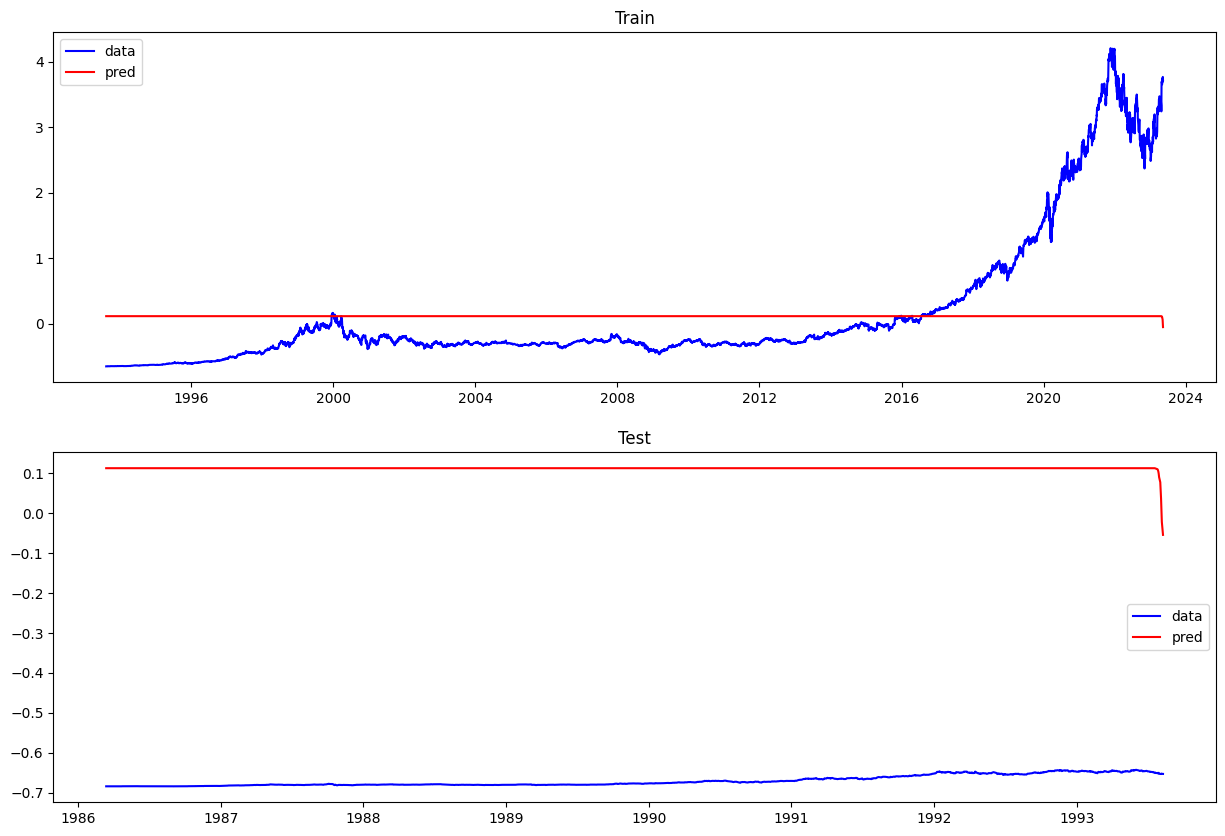

In [36]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

In [ ]:
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device, n_prior = 30, n_forecast = 100)
plt.title('Test')